Adel Movahedian 400102074

# Data Visualization & Feature Engineering on the Online Retail Dataset

This notebook demonstrates various data visualization and feature engineering techniques on the Online Retail dataset from the UCI Machine Learning Repository. We will:
- Visualize data distributions and trends.
- Create new features including:
  - **Ratio features, binning, function transformation, and combining columns**
  - **Date/time features extraction**
  - **Counts and aggregation**
- Perform feature selection based on Mutual Information.
- Apply dimensionality reduction using PCA.
- Discuss when feature engineering is a “nice to have” versus a “must to have.”

The dataset contains transactional data with fields such as InvoiceNo, InvoiceDate, Quantity, UnitPrice, and Country, which makes it ideal for our assignment.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set visualization style
sns.set(style="whitegrid", context="talk")

# Load the Online Retail dataset (download the Excel file from UCI repository and save as 'Online Retail.xlsx')
df = pd.read_excel('Online Retail.xlsx')

# Display first few rows and basic info
print("Dataset shape:", df.shape)
print(df.head())
df.info()


Dataset shape: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
--

<font color = "green"> We import required libraries, load the dataset (assumed to be downloaded locally from the UCI repository), and inspect its shape and contents.

Missing values per column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


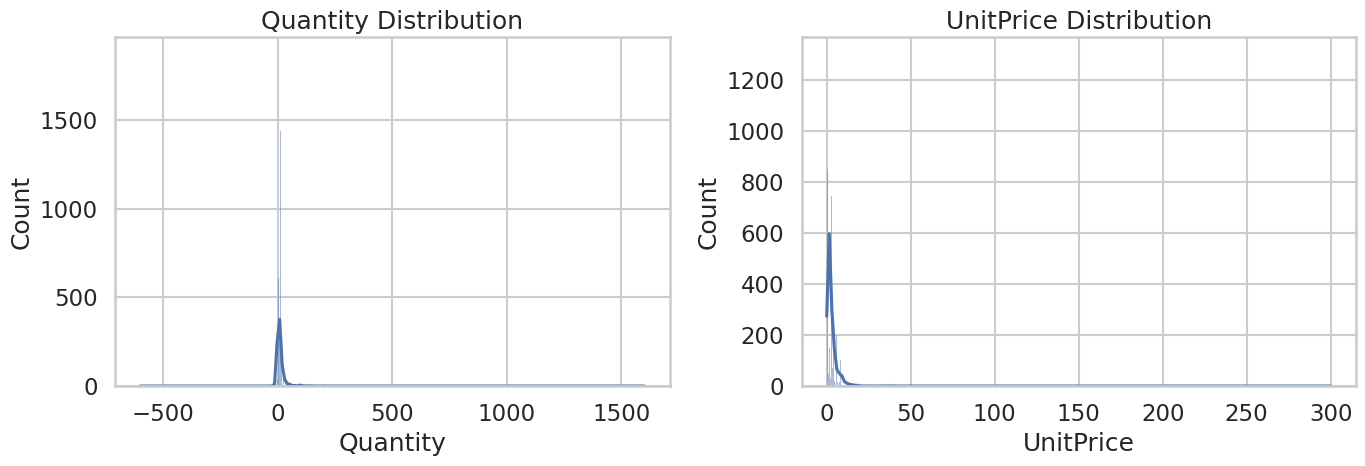

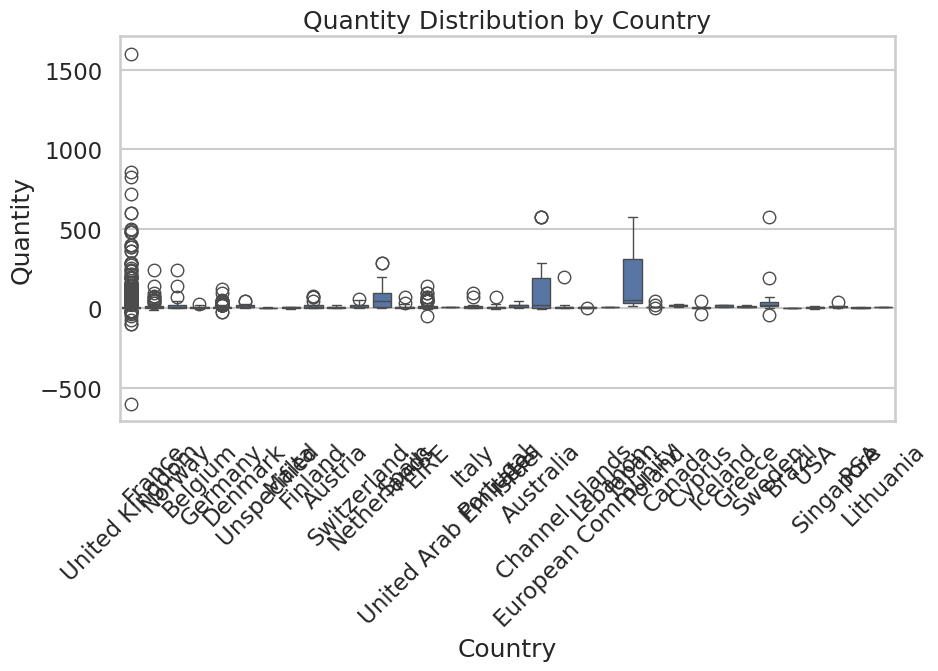

In [5]:
# Check missing values on the entire dataset
print("Missing values per column:\n", df.isnull().sum())

# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# If the dataset is very large, take a random sample for plotting
df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df

# Visualize distribution of Quantity and UnitPrice using the sample
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_sample['Quantity'], kde=True, ax=axes[0]).set_title("Quantity Distribution")
sns.histplot(df_sample['UnitPrice'], kde=True, ax=axes[1]).set_title("UnitPrice Distribution")
plt.tight_layout()
plt.show()

# Visualize Quantity across Countries using a boxplot with the sample
plt.figure(figsize=(10, 5))
sns.boxplot(x='Country', y='Quantity', data=df_sample)
plt.xticks(rotation=45)
plt.title("Quantity Distribution by Country")
plt.show()


<font color = "green"> We check for missing data and drop rows missing CustomerID (important for aggregations later). Then we plot histograms for Quantity and UnitPrice and a boxplot to see how Quantity varies by Country.

In [6]:
# Create a new feature 'Sales' as Quantity * UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']

# For demonstration, assume a synthetic cost as 70% of Sales
df['Cost'] = df['Sales'] * 0.7
# Compute profit and ratio (profit to cost)
df['Profit'] = df['Sales'] - df['Cost']
df['Profit_Cost_Ratio'] = df['Profit'] / df['Cost']

# Binning: Bin 'Sales' into 4 quantile-based categories
df['Sales_Bin'] = pd.qcut(df['Sales'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Function transformation: Apply a square root transformation on Sales
df['Sqrt_Sales'] = np.sqrt(df['Sales'])

# Combining columns: Create a new feature by concatenating InvoiceNo and Country
df['Invoice_Country'] = df['InvoiceNo'].astype(str) + "_" + df['Country'].astype(str)

# Show sample of new features
df[['Sales', 'Cost', 'Profit', 'Profit_Cost_Ratio', 'Sales_Bin', 'Sqrt_Sales', 'Invoice_Country']].head()


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Sales,Cost,Profit,Profit_Cost_Ratio,Sales_Bin,Sqrt_Sales,Invoice_Country
0,15.30,10.710,4.590,0.428571,High,3.911521,536365_United Kingdom
1,20.34,14.238,6.102,0.428571,Very High,4.509989,536365_United Kingdom
2,22.00,15.400,6.600,0.428571,Very High,4.690416,536365_United Kingdom
3,20.34,14.238,6.102,0.428571,Very High,4.509989,536365_United Kingdom
4,20.34,14.238,6.102,0.428571,Very High,4.509989,536365_United Kingdom


<font color = "green"> We compute a synthetic Sales feature, assume a cost (70% of sales) to derive Profit and then the Profit_Cost_Ratio. We also bin the Sales, apply a square root transformation to reduce skewness, and combine InvoiceNo with Country into a new string feature.

In [7]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract date/time components: day, month, year, and day of week
df['Day'] = df['InvoiceDate'].dt.day
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

# Display the new date/time features
df[['InvoiceDate', 'Day', 'Month', 'Year', 'DayOfWeek']].head()


,InvoiceDate,Day,Month,Year,DayOfWeek
0,2010-12-01 08:26:00,1,12,2010,Wednesday
1,2010-12-01 08:26:00,1,12,2010,Wednesday
2,2010-12-01 08:26:00,1,12,2010,Wednesday
3,2010-12-01 08:26:00,1,12,2010,Wednesday
4,2010-12-01 08:26:00,1,12,2010,Wednesday


<font color = "green"> We convert the InvoiceDate into a proper datetime format and extract several useful time-related features for later aggregation and analysis.

Aggregated metrics by Country:
                 Country  Invoice_Count  Total_Sales  Avg_Profit
0              Australia             69   137077.270   32.663369
1                Austria             19    10154.320    7.596748
2                Bahrain              2      548.400    9.677647
3                Belgium            119    40910.960    5.931990
4                 Brazil              1     1143.600   10.721250
5                 Canada              6     3666.380    7.284199
6        Channel Islands             33    20086.290    7.949719
7                 Cyprus             20    12946.290    6.244191
8         Czech Republic              5      707.720    7.077200
9                Denmark             21    18768.140   14.474144
10                  EIRE            319   250285.220   10.031472
11    European Community              5     1291.750    6.352869
12               Finland             48    22326.740    9.637442
13                France            458   196712.840    6.9

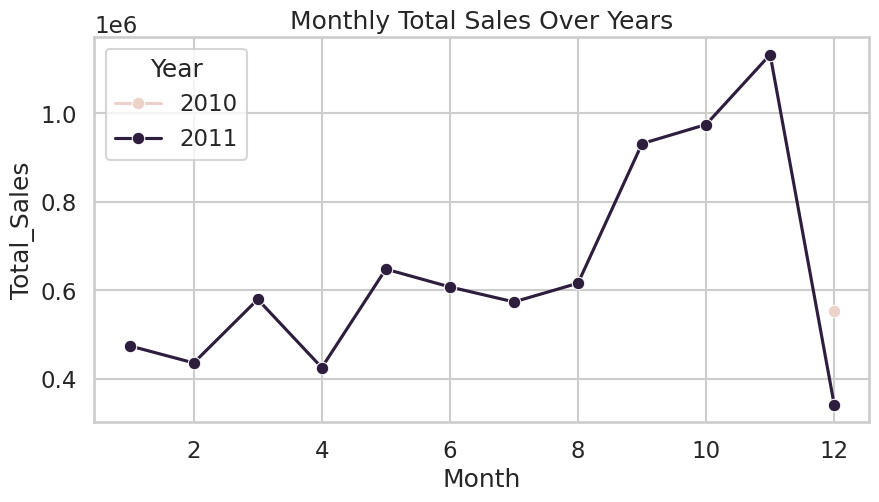

In [8]:
# Aggregation by Country: Count number of invoices and total sales per country
agg_country = df.groupby('Country').agg(
    Invoice_Count=('InvoiceNo', 'nunique'),
    Total_Sales=('Sales', 'sum'),
    Avg_Profit=('Profit', 'mean')
).reset_index()

print("Aggregated metrics by Country:")
print(agg_country)

# Count invoices per month to observe temporal patterns
monthly_sales = df.groupby(['Year', 'Month']).agg(
    Invoice_Count=('InvoiceNo', 'nunique'),
    Total_Sales=('Sales', 'sum')
).reset_index()

# Visualize monthly total sales
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_sales, x='Month', y='Total_Sales', hue='Year', marker='o')
plt.title("Monthly Total Sales Over Years")
plt.show()


<font color = "green"> We group the data by Country to compute invoice counts, total sales, and average profit. We also aggregate monthly sales (grouped by Year and Month) and plot the trend.

In [9]:
from sklearn.feature_selection import mutual_info_classif

# For feature selection, create a binary target: 'HighProfit' if Profit > median profit, else 0
median_profit = df['Profit'].median()
df['HighProfit'] = (df['Profit'] > median_profit).astype(int)

# Select numerical features to evaluate (exclude date/time and categorical ones)
features = ['Quantity', 'UnitPrice', 'Sales', 'Cost', 'Profit', 'Profit_Cost_Ratio', 'Sqrt_Sales']
X = df[features].fillna(0)
y = df['HighProfit']

# Compute Mutual Information scores
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=features).sort_values(ascending=False)

print("Mutual Information scores for numerical features:")
print(mi_series)


Mutual Information scores for numerical features:
Sqrt_Sales           0.693991
Sales                0.693181
Cost                 0.693164
Profit               0.693156
Quantity             0.201883
UnitPrice            0.092532
Profit_Cost_Ratio    0.042096
dtype: float64


<font color = "green"> We create a binary target (HighProfit) based on whether profit is above the median. Then we calculate the mutual information scores for several numeric features, which helps us identify which features are most informative for predicting profitability.

Explained Variance Ratio by PCA components: [0.57410115 0.14857694]


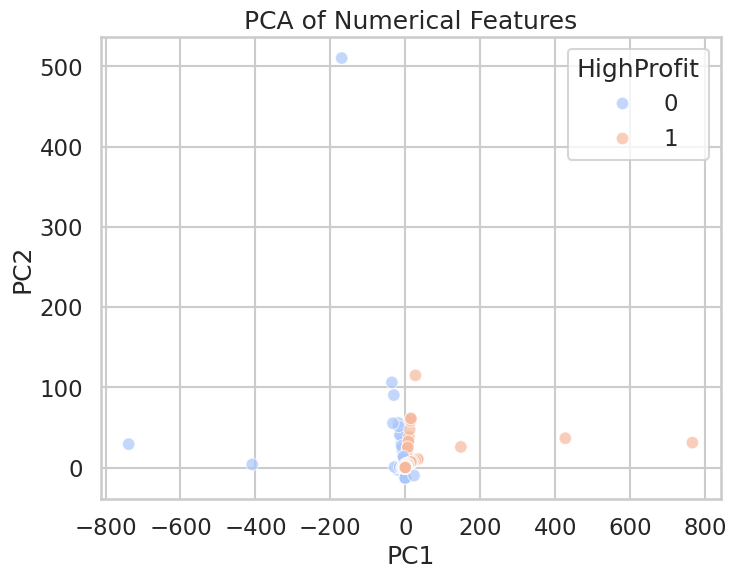

In [10]:
# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensions (reduce to 2 components for visualization)
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results and target variable
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['HighProfit'] = y.values

print("Explained Variance Ratio by PCA components:", pca.explained_variance_ratio_)

# Visualize the PCA result
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='HighProfit', palette='coolwarm', alpha=0.7)
plt.title("PCA of Numerical Features")
plt.show()


<font color="green"> We standardize our numeric features and apply PCA to reduce dimensionality to two components for easier visualization. The explained variance is printed, and a scatter plot shows how well the two principal components separate the high-profit transactions.

## When is Feature Engineering a “Nice to Have” vs. a “Must to Have”?

Feature engineering is a **"nice to have"** when:
- The raw data is already highly informative and structured.
- Modern machine learning models (e.g., deep learning) are capable of automatically extracting non-linear relationships from large volumes of data.
- The baseline model performance is already strong and further improvements are incremental.

On the other hand, feature engineering becomes a **"must to have"** when:
- The raw data is noisy, unstructured, or missing key domain-specific signals.
- The performance of the model is limited by the quality of the input features.
- Domain knowledge can be applied to create new, informative representations that significantly boost model performance.
- Computational resources or data volumes are limited, requiring more efficient and compact features for improved interpretability and faster model training.

In summary, for complex, heterogeneous, or noisy datasets—like many real-world retail transactions—feature engineering is essential to unlock hidden patterns and drive significant performance gains.
